In [14]:
import sys
import os
sys.path.append('..')
import numpy as np
import pandas as pd
from models import sir
from config import get_project_root

In [15]:
DATA_FOLDER = f'{get_project_root()}/data'
INFECTADOS_PATH = f'{DATA_FOLDER}/extrapolated/infectados_extrapolado.csv'
HABITANTES_PATH = f'{DATA_FOLDER}/extrapolated/habitantes_extrapolado.csv'
VACUNADOS_PATH = f'{DATA_FOLDER}/extrapolated/vacunados_extrapolado.csv'
YEARS = [2018, 2019, 2020, 2021, 2022]
MONTHS = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGOS', 'SEP', 'OCT', 'NOV', 'DIC']


In [16]:
habitantes_curve = pd.read_csv(HABITANTES_PATH).set_index('ANO')
for month in MONTHS:
    habitantes_curve[month] = habitantes_curve['JUL']
max_habs = habitantes_curve.max().max()
max_habs

11101945

In [17]:
def extract_curve(path=None, df=None):
    if df is None:
        df = pd.read_csv(path).set_index('ANO')
    df = df[df.columns[:12]].T
    values = []
    for year in YEARS:
        values.extend(df[year].tolist())
    return pd.Series(values)

infectuous_curve = extract_curve(path=INFECTADOS_PATH)  
vacunados_curve = extract_curve(path=VACUNADOS_PATH)
recovered_curve = pd.Series([0]*len(infectuous_curve))
max_habs = max([habitantes_curve.max().max(), vacunados_curve.max().max()])

In [18]:
habitantes_curve

,ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGOS,SEP,OCT,NOV,DIC
ANO,,,,,,,,,,,,
2018,10973470,10973470,10973470,10973470,10973470,10973470,10973470,10973470,10973470,10973470,10973470,10973470
2019,11012606,11012606,11012606,11012606,11012606,11012606,11012606,11012606,11012606,11012606,11012606,11012606
2020,11047665,11047665,11047665,11047665,11047665,11047665,11047665,11047665,11047665,11047665,11047665,11047665
2021,11077856,11077856,11077856,11077856,11077856,11077856,11077856,11077856,11077856,11077856,11077856,11077856
2022,11101945,11101945,11101945,11101945,11101945,11101945,11101945,11101945,11101945,11101945,11101945,11101945


In [19]:
for ix, val in enumerate(infectuous_curve):
    try:
        recovered_curve[ix+1] += val
    except KeyError:
        continue

In [20]:
susceptible_curve = max_habs - infectuous_curve - vacunados_curve - recovered_curve



In [21]:
data = pd.concat([susceptible_curve, infectuous_curve, recovered_curve, vacunados_curve], axis=1)[:59]


In [22]:
data_numpy = np.array(data)/max_habs

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [42]:
class SIRV(nn.Module):
    def __init__(self, epsilon=1e-7):
        super(SIRV, self).__init__()
        self.lambda1 = nn.Linear(1,1, bias = False) # tasa de contacto efectivo
        self.lambda2 = nn.Linear(1,1, bias = False) # tasa de immunizacion
        self.lambda3 = nn.Linear(1,1, bias = False) # tasa de recuperacion
        torch.nn.init.normal_(self.lambda1.weight)
        torch.nn.init.normal_(self.lambda2.weight)
        torch.nn.init.normal_(self.lambda3.weight)
        self.epsilon = epsilon
    
    def forward(self, x, n):
        ns = torch.randn([n, 4],dtype=torch.float, requires_grad = False)
        x[x==0] = self.epsilon
        ns[0] = x.view(1, 4).clone()
        for i in range(1,n):
            a = ns[i-1].clone()
            ns[i][0] = a[0].view(1,1) - self.lambda1(a[0]*a[1].view(1,1)) - self.lambda2(a[0].view(1,1))
            ns[i][1] = a[1].view(1,1) + self.lambda1(a[0]*a[1].view(1,1)) - self.lambda3(a[1].view(1,1))  - self.lambda2(a[1].view(1,1))
            ns[i][2] = a[2].view(1,1) + self.lambda3(a[1].view(1,1))
            ns[i][3] = a[3].view(1,1) + self.lambda2(a[1].view(1,1))
        return ns[1:].reshape(-1,4)


In [56]:
def loss_custom(pred, actual):
    loss_func = nn.SmoothL1Loss()
    loss_big = loss_func(pred[:,3], actual[:,3]) + loss_func(pred[:,0], actual[:,0])
    loss_small = loss_func(pred[:,1], actual[:,1]) + loss_func(pred[:,2], actual[:,2])
    return 10000*loss_small + 0.01*loss_big

In [57]:
DOWNSAMPLE = 10000
y = torch.from_numpy(data_numpy.astype(np.float32))/DOWNSAMPLE
#downscaled by 10000 to avoid gradient explosion
epsilon = 1e-15
sir = SIRV()



In [58]:
sir(y[0], 10)

tensor([[1.7554e-05, 4.3248e-08, 1.3570e-07, 7.7785e-05],
        [1.3858e-05, 1.8704e-08, 1.5113e-07, 7.7794e-05],
        [1.0940e-05, 8.0891e-09, 1.5781e-07, 7.7798e-05],
        [8.6368e-06, 3.4984e-09, 1.6070e-07, 7.7800e-05],
        [6.8183e-06, 1.5130e-09, 1.6195e-07, 7.7800e-05],
        [5.3827e-06, 6.5437e-10, 1.6249e-07, 7.7801e-05],
        [4.2494e-06, 2.8301e-10, 1.6272e-07, 7.7801e-05],
        [3.3547e-06, 1.2240e-10, 1.6282e-07, 7.7801e-05],
        [2.6483e-06, 5.2937e-11, 1.6286e-07, 7.7801e-05]],
       grad_fn=<ReshapeAliasBackward0>)

In [59]:
opt = torch.optim.Adam(sir.parameters(), lr=0.05)
loss_func = nn.SmoothL1Loss()
best = 10000
for epoch in range(1000):
    out = sir(y[0], len(y))
    out = out.squeeze()
    loss = loss_custom(out, y[1:])
    loss.backward()
    opt.step() 
    opt.zero_grad()
    if loss.item() < best:
        best = loss.item()
        torch.save(sir, 'sir.pkl')
    if epoch%100 == 0:        
        print(f'Epoch: {epoch}, loss: {loss.item()}')
    if loss.isnan():
        raise ValueError()

Epoch: 0, loss: 1.2826711914826205e-10
Epoch: 100, loss: 1.1093195112499288e-10
Epoch: 200, loss: 9.626223429481939e-11
Epoch: 300, loss: 8.176930660352966e-11
Epoch: 400, loss: 6.530159052386963e-11
Epoch: 500, loss: 4.329784100698397e-11
Epoch: 600, loss: 1.1611339494066453e-11
Epoch: 700, loss: 4.89071977360922e-12
Epoch: 800, loss: 4.842167465601843e-12
Epoch: 900, loss: 4.796052877759083e-12


In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
model = torch.load('sir.pkl')
window = 10
y = torch.from_numpy(data_numpy.astype(np.float32))/DOWNSAMPLE
h = y[0]
res = model(h,85)


/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5056/3246194117.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('accumul_prediction.png', format='png', linewidth = 0.01)


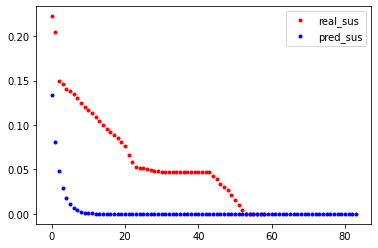

In [61]:
predicted_susceptible = res[:,0].detach().numpy()*DOWNSAMPLE
real_susceptible = y[:,0].detach().numpy()*DOWNSAMPLE
plt.plot(real_susceptible, color = 'r', linewidth=0, marker='.', label='real_sus')
plt.plot(predicted_susceptible, color = 'b', linewidth=0, marker='.', label='pred_sus')
plt.legend()
plt.savefig('accumul_prediction.png', format='png', linewidth = 0.01)

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5056/895472032.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('accumul_prediction_vaccinated.png', format='png', linewidth = 0.01)


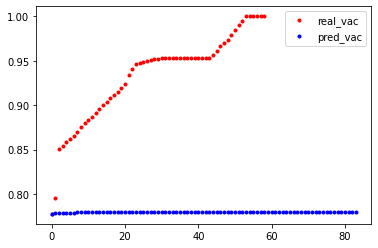

In [62]:
predicted_vaccinated = res[:,3].detach().numpy()*DOWNSAMPLE
real_vaccinated = y[:,3].detach().numpy()*DOWNSAMPLE
plt.plot(real_vaccinated, color = 'r', linewidth=0, marker='.', label='real_vac')
plt.plot(predicted_vaccinated, color = 'b', linewidth=0, marker='.', label='pred_vac')
plt.legend()
plt.savefig('accumul_prediction_vaccinated.png', format='png', linewidth = 0.01)

Que pasa si le damos mas peso a fitear a los susceptibles?


/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5056/1440621252.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('accumul_infected.png', format='png', linewidth = 0.01)


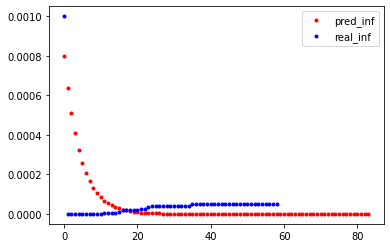

In [63]:
predicted_infected = res[:,1].detach().numpy()*DOWNSAMPLE
real_infected = y[:,1].detach().numpy()*DOWNSAMPLE
plt.plot(predicted_infected, color = 'r', linewidth=0, marker='.', label='pred_inf')
plt.plot(real_infected, color = 'b', linewidth=0, marker='.', label='real_inf')
plt.legend()
plt.savefig('accumul_infected.png', format='png', linewidth = 0.01)

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_5056/2215597654.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('accumul_prediction_rec.png', format='png', linewidth = 0.01)


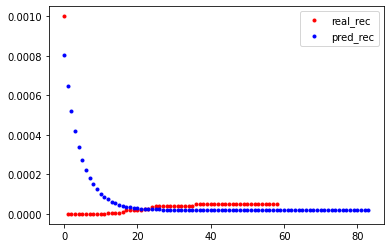

In [64]:
predicted_recov = res[:,2].detach().numpy()*DOWNSAMPLE
real_recov = y[:,2].detach().numpy()*DOWNSAMPLE
plt.plot(real_recov, color = 'r', linewidth=0, marker='.', label='real_rec')
plt.plot(predicted_recov, color = 'b', linewidth=0, marker='.', label='pred_rec')
plt.legend()
plt.savefig('accumul_prediction_rec.png', format='png', linewidth = 0.01)